## Federal Reserve Economic Data (FRED)

The macroeconomic data from FRED is related to my previous datasets of the Index of Economic Freedom.

Data souce: https://data.nasdaq.com/data/FRED-federal-reserve-economic-data

## Importing libraries and data

In [156]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that 
# handles statistical models.
import os
import warnings # This is a library that handles warnings.
import nasdaqdatalink



## Configuring API

In [157]:
# Configure API key 

quandl.ApiConfig.api_key = 'MDrK6DuFKTzfUCXACp-U'

## Importing data for analysis


In [158]:
# Importing the Federal Reserve Economic Data "Natural Rate of Unemployment" variable.

data_FRED = quandl.get('FRED/NROUST')

## Checking the data

In [159]:
data_FRED.head()

,Value
Date,
1949-01-01,5.255053
1949-04-01,5.261516
1949-07-01,5.268013
1949-10-01,5.274564
1950-01-01,5.281182


In [160]:
data_FRED.shape

(332, 1)

In [161]:
data_FRED.columns

Index(['Value'], dtype='object')

In [162]:
type(data_FRED)

pandas.core.frame.DataFrame

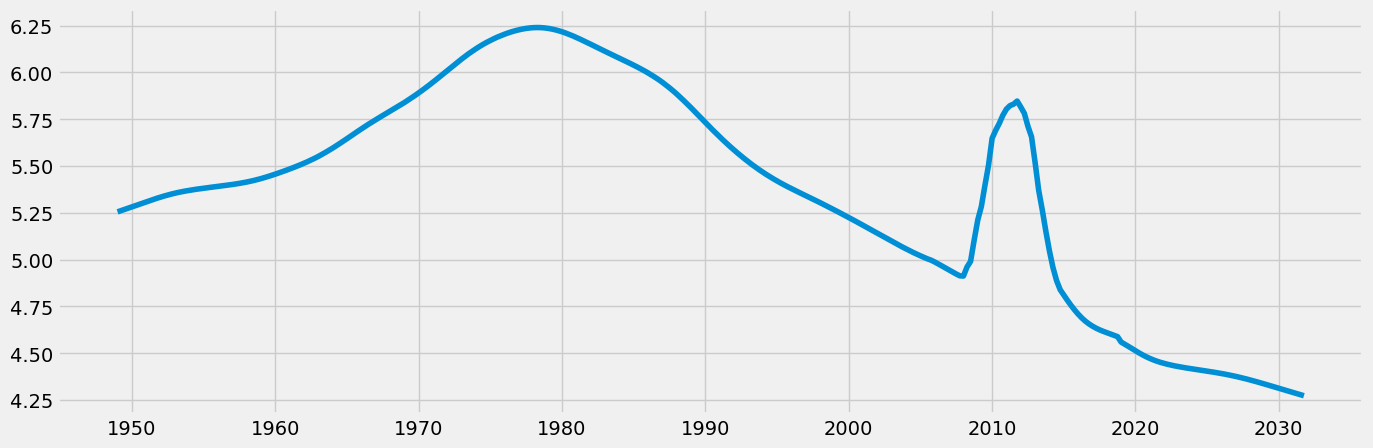

In [163]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. 
# When it's set to 100, it will produce lower-than-standard quality, which is useful if, similar to this notebook, 
# you'll have a lot of plots. A large number of plots will increase the size of the notebook, 
# which could take more time to load and eat up a lot of RAM!

plt.plot(data_FRED)

In [164]:
# Check for missing values (you shouldn't have any)

data_FRED.isnull().sum() 

Value    0
dtype: int64

In [165]:
# Check for duplicates

dups = data_FRED.duplicated()
dups.sum() # No dups!

0

## Subsetting and cleaning of the data

In [166]:
# Resetting index so that you can use the "Date" column as a filter

data_FRED_2 = data_FRED.reset_index()

In [167]:
data_FRED_2.head()

,Date,Value
0,1949-01-01,5.255053
1,1949-04-01,5.261516
2,1949-07-01,5.268013
3,1949-10-01,5.274564
4,1950-01-01,5.281182


In [168]:
# Producing a subset for data from 1995 (data range of my primary data set) until February of 2021.
# It says on the website that the data has been refreshed on Feb. 1st, 2021. 
# The data also contains forecasted values until 2031 but I only use historic and not forecasted data.

data_FRED_sub = data_FRED_2.loc[(data_FRED_2['Date'] >= '1995-01-01') & (data_FRED_2['Date'] < '2021-02-01')]

In [169]:
data_FRED_sub.shape

(105, 2)

In [170]:
data_FRED_sub.head()

,Date,Value
184,1995-01-01,5.420172
185,1995-04-01,5.409451
186,1995-07-01,5.399091
187,1995-10-01,5.389050
188,1996-01-01,5.379276


In [171]:
data_FRED_sub.tail()

,Date,Value
284,2020-01-01,4.512876
285,2020-04-01,4.501435
286,2020-07-01,4.490658
287,2020-10-01,4.480756
288,2021-01-01,4.471833


The observations available for the Nasdaq source are from 01/01/1995 until 01/01/2021 and updated quarterly.

In [172]:
# Setting the "Date" column as the index

from datetime import datetime

data_FRED_sub['datetime'] = pd.to_datetime(data_FRED_sub['Date']) # Create a datetime column from "Date"
data_FRED_sub = data_FRED_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_FRED_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_FRED_sub.head()

,Value
datetime,
1995-01-01,5.420172
1995-04-01,5.409451
1995-07-01,5.399091
1995-10-01,5.389050
1996-01-01,5.379276


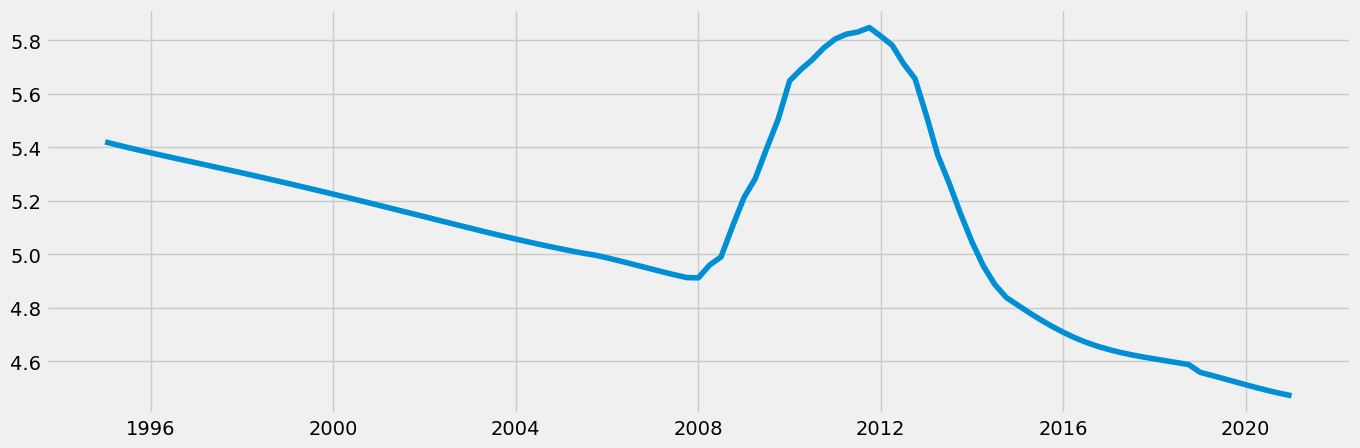

In [173]:
# Plotting the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_FRED_sub)

## Decomposing of the data for time-series analysis

In [174]:
# Decomposing the time series using an additive model

decomposing = sm.tsa.seasonal_decompose(data_FRED_sub, model='additive')

In [175]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

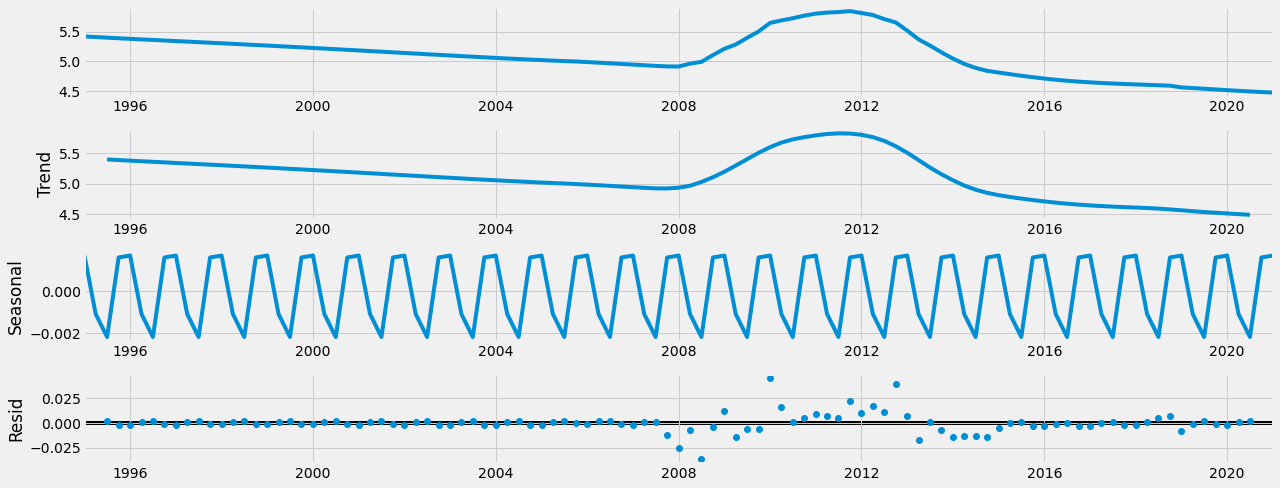

In [176]:
# Plotting the separate components

decomposing.plot()
plt.show()

The trend appear the same because the data doesn't present huge variations, but some from 2008 to 2014.
The residual line presents higher variations from 2008 (housing crises in the US).
The seasonal line shows that the data has seasonality, potentially promoted by the crisis and seasonal jobs.

## Testing for stationarity

In [177]:
# The adfuller() function will import from the model from statsmodels for the test; however, 
# running it will only return an array of numbers. 
# This is the resaon to define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_FRED_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -0.491166
p-value                         0.893729
Number of Lags Used            12.000000
Number of Observations Used    92.000000
Critical Value (1%)            -3.503515
Critical Value (5%)            -2.893508
Critical Value (10%)           -2.583824
dtype: float64


In order to determine the results of a statistical hypothesis test, one has to compare the **test statistic** to the **critical value** of the corresponding significance level. 

If the **test statistic** is larger than the **critical value**, one can’t reject the null hypothesis. 
If the **test statistic** is smaller than the **critical value**, the null hypothesis could be rejected. 

In this case, considering a significance level of 5%, the “Critical Value of 5% has a value of -2.893508. This is smaller than the **test statistic**, which is -0.491166, which means that the null hypothesis cannot be rejected.

This also means that the data is non-stationary. 

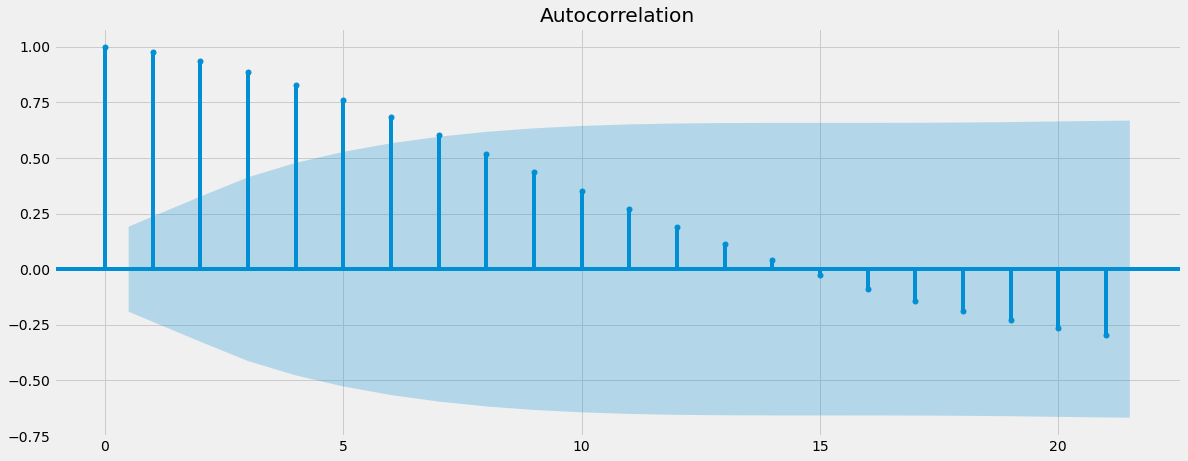

In [178]:
# Checking out autocorrelations with a plot

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Import autocorrelation and partial correlation plots.

plot_acf(data_FRED_sub)
plt.show()

The vertical lines represent the lags in the series, while the blue area represents the confidence interval. When lines go above the blue edge of the confidence interval, this means there are lags that are significantly correlated with each other. Thus, it can be deduced that the data is non-stationary.

## Stationarizing the data

In [179]:
data_diff = data_FRED_sub - data_FRED_sub.shift(1) # The df.shift(1) function turns the observation to t-1, 
# making the whole data t - (t -1)

In [180]:
data_diff.dropna(inplace = True) # Missing values that came about as a result of the differencing are removed. 
# They need to be removed or the Dickey-Fuller test won't run.

In [181]:
data_diff.head()

,Value
datetime,
1995-04-01,-0.010721
1995-07-01,-0.010360
1995-10-01,-0.010041
1996-01-01,-0.009774
1996-04-01,-0.009567


In [182]:
data_diff.tail()

,Value
datetime,
2020-01-01,-0.011806
2020-04-01,-0.011441
2020-07-01,-0.010777
2020-10-01,-0.009902
2021-01-01,-0.008923


In [183]:
data_diff.columns

Index(['Value'], dtype='object')

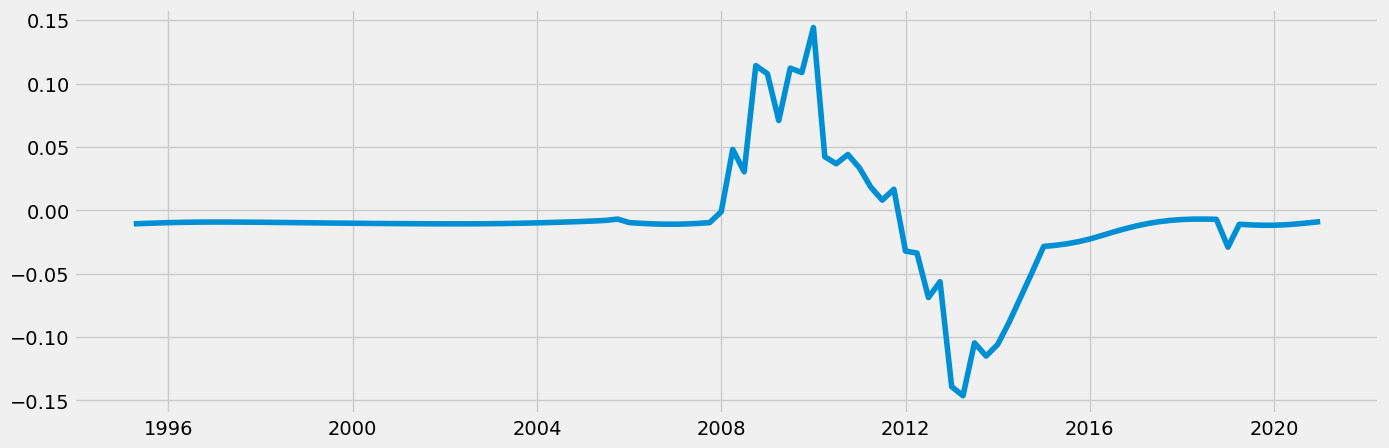

In [184]:
# Checking out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

Stationarizing the data, the visual patterns are more visible and the data presented trend changes.

In [185]:
# Running the Dickey-Fuller-Test again

dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -3.647093
p-value                         0.004922
Number of Lags Used            11.000000
Number of Observations Used    92.000000
Critical Value (1%)            -3.503515
Critical Value (5%)            -2.893508
Critical Value (10%)           -2.583824
dtype: float64


The results means that null hypothesis cannot be rejected and the data is still non-stationary. 

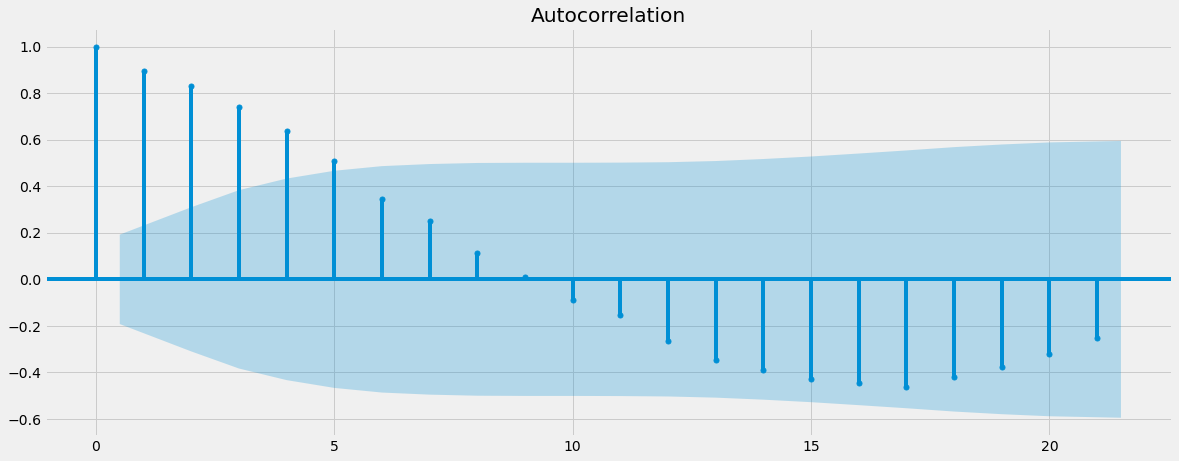

In [186]:
# Plotting the autocorrelation again

plot_acf(data_diff)
plt.show()

Although the autocorrelation plot has improved, the data are still not stationary. But even though I don't see the need to conduct another analysis cycle as there is not a significant amount of vertical lines above the confidence interval = blue line.